In [18]:
import pandas as pd
import numpy as np
import glob
from tqdm.notebook import tqdm

OPENALEX = '/scratch/fl1092/OpenAlex/openalex'

def printShape(df, cols=[], msg=''):
    
    print(df.shape, end='  ')
    for col in cols:
        print(col, df[col].nunique(), end='  ')
    print(msg)
    
    return df

OPENALEX = '/scratch/fl1092/OpenAlex/openalex'
DIR = '../data/study_2_data'
LARGEFILE = '../data/large'
SCISCINET = '/scratch/fl1092/SciSciNet'

PaperIDtoInt = lambda x: int(x.replace('https://openalex.org/W', ''))

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

CM = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

## Data

In [3]:
%%time
paperJournal = (
    pd.read_csv(f'{LARGEFILE}/PaperJournal.csv', usecols=['PaperID','JournalID'])
    .pipe(printShape)

    .drop_duplicates(subset=['PaperID'])
    .pipe(printShape, cols=['PaperID'])
)

(215542989, 2)  
(208261724, 2)  PaperID 208261724  
CPU times: user 2min 40s, sys: 5.64 s, total: 2min 45s
Wall time: 2min 58s


In [4]:
%%time
paperYear = (
    pd.read_csv(f'{LARGEFILE}/PaperYear.csv', usecols=['PaperID','Year'])
    .pipe(printShape, cols=['PaperID'])
)

(257748845, 2)  PaperID 257748845  
CPU times: user 1min 37s, sys: 3.97 s, total: 1min 41s
Wall time: 1min 49s


### Region of papers

In [5]:
%%time
authorCount = pd.read_csv(f'{LARGEFILE}/PaperAuthorCount.csv').pipe(printShape)

(235722554, 2)  
CPU times: user 29.8 s, sys: 2.17 s, total: 32 s
Wall time: 34.8 s


In [63]:
%%time
paperSubRegion = (
    pd.read_csv(f'{OPENALEX}/cleaned_data/PaperSubRegion.csv').pipe(printShape)
    .merge(authorCount.rename(columns={'AuthorCount':'Total'}), on='PaperID').pipe(printShape)
    .assign(Percentage=lambda df: df.Count/df.Total)
    .query('Percentage > 0.5').pipe(printShape)
    .drop_duplicates(subset=['PaperID'], keep=False).pipe(printShape, cols=['PaperID'])
    .drop(['Count','Total','Percentage'], axis=1)
) # 87508681

(118629199, 3)  
(118629199, 4)  
(91019327, 5)  
(87508681, 5)  PaperID 87508681  
CPU times: user 1min 33s, sys: 7.88 s, total: 1min 41s
Wall time: 1min 46s


### Whether the paper itself is OA

In [8]:
%%time
worksOA = (
    pd.read_csv(
        f'{OPENALEX}/raw_data/works_open_access.csv.gz',
        usecols=['work_id','is_oa']
    )
    .assign(PaperID=lambda df: df.work_id.apply(PaperIDtoInt))
    .drop(['work_id'], axis=1)
    .pipe(printShape, cols=['PaperID'])
)

(257748845, 2)  PaperID 257748845  
CPU times: user 9min 42s, sys: 17.1 s, total: 9min 59s
Wall time: 10min 42s


### Percentage of citations that goes to OA papers

In [10]:
%%time
paperOACount = (
    pd.read_csv(f'{LARGEFILE}/PaperCitingOACount.csv').pipe(printShape, cols=['CitingPaperID'])
    .query('is_oa==True')
    .pipe(printShape, cols=['CitingPaperID'])
    
    .drop(['is_oa'], axis=1)
    .rename(columns={'CitingPaperID':'PaperID'})

    .groupby('PaperID')['count'].sum().reset_index()
    .pipe(printShape, cols=['PaperID'])
)

(155981427, 3)  CitingPaperID 87336219  
(71458850, 3)  CitingPaperID 71458673  
(71458673, 2)  PaperID 71458673  
CPU times: user 2min, sys: 4.04 s, total: 2min 4s
Wall time: 2min 10s


In [35]:
%%time
totalRef = pd.read_csv(f'{LARGEFILE}/PaperReferencesCount.csv').pipe(printShape) # 87419190

(87419190, 2)  
CPU times: user 11.9 s, sys: 547 ms, total: 12.4 s
Wall time: 12.9 s


In [37]:
%%time
paperPaywalledPercent = (
    paperOACount
    .merge(totalRef, on='PaperID', how='right')
    .pipe(printShape, cols=['PaperID'])
    
    .fillna({'count': 0})
    .assign(Percent=lambda df: 1- (df['count'] / df.ReferencesCount)) # "count" is number of references that goes to OA papers

    .merge(paperJournal, on='PaperID')
    .pipe(printShape, cols=['PaperID'])

    .assign(Percent_within=lambda df: df.groupby('JournalID')['Percent'].transform(lambda x: x - np.mean(x)))
    .pipe(printShape)

    .drop(['JournalID'], axis=1)
)

(87419190, 3)  PaperID 87419190  
(78821844, 5)  PaperID 78821844  
(78821844, 6)  
CPU times: user 2min 58s, sys: 13 s, total: 3min 11s
Wall time: 3min 13s


In [38]:
del paperOACount
del totalRef

### Paper relative citation count, disruptiveness and novelty

In [ ]:
%%time
citationCount = pd.read_csv(f'{LARGEFILE}/RelativeCitationCount.csv')

In [ ]:
%%time
novelty = (
    pd.read_csv(
        f'{SCISCINET}/SciSciNet_Papers.tsv', sep='\t',
        usecols=['PaperID','Disruption','Atyp_10pct_Z']
    )
    .pipe(printShape) # 134129188

    .merge(paperJournal, on='PaperID')
    .pipe(printShape)

    .merge(paperYear, on='PaperID')
    .pipe(printShape) # 115940771
)

### Paper team size

In [14]:
%%time
authorCount = (
    pd.read_csv(f'{LARGEFILE}/PaperAuthorCount.csv')
    .rename(columns={'Count': 'AuthorCount'})
    .pipe(printShape, cols=['PaperID'])
)

(235722554, 2)  PaperID 235722554  
CPU times: user 1min 35s, sys: 4.42 s, total: 1min 40s
Wall time: 1min 41s


## Regressional analysis

In [40]:
%%time
toRegress = (
    citationCount.pipe(printShape)
    .merge(paperPaywalledPercent, on='PaperID').pipe(printShape)
    .merge(worksOA, on='PaperID').pipe(printShape)
    .merge(authorCount, on='PaperID').pipe(printShape)
)

(208261724, 5)  
(78821844, 9)  
(78821844, 10)  
(77887862, 11)  
CPU times: user 4min 51s, sys: 26.8 s, total: 5min 18s
Wall time: 5min 19s


In [42]:
%%time
noveltyToRegress = (
    novelty[['PaperID','Atyp_10pct_Z','JournalID','Year']].dropna().pipe(printShape)
    .assign(Novelty_within=lambda df: df.groupby('JournalID')['Atyp_10pct_Z'].transform(lambda x: x - np.mean(x)))
    .pipe(printShape)
    
    .merge(paperPaywalledPercent, on='PaperID').pipe(printShape)
    .merge(worksOA, on='PaperID').pipe(printShape)
    .merge(authorCount, on='PaperID').pipe(printShape)
)

(43753561, 4)  
(43753561, 5)  
(43681305, 9)  
(43681305, 10)  
(43623411, 11)  
CPU times: user 3min 56s, sys: 19.5 s, total: 4min 15s
Wall time: 4min 17s


In [43]:
%%time
disruptionToRegress = (
    novelty[['PaperID','Disruption','JournalID','Year']].dropna().pipe(printShape)
    .assign(Disruption_within=lambda df: df.groupby('JournalID')['Disruption'].transform(lambda x: x - np.mean(x)))
    .pipe(printShape)
    
    .merge(paperPaywalledPercent, on='PaperID').pipe(printShape)
    .merge(worksOA, on='PaperID').pipe(printShape)
    .merge(authorCount, on='PaperID').pipe(printShape)

)

(45706411, 4)  
(45706411, 5)  
(45473240, 9)  
(45473240, 10)  
(45391625, 11)  
CPU times: user 4min 8s, sys: 19.7 s, total: 4min 27s
Wall time: 4min 29s


In [44]:
assert(toRegress.isna().any().any()==False)
assert(noveltyToRegress.isna().any().any()==False)
assert(disruptionToRegress.isna().any().any()==False)

In [45]:
from statsmodels.formula.api import ols, logit
from scipy.stats import ttest_ind
from statsmodels.iolib.summary2 import summary_col

import numpy as np

In [46]:
def getCurve(x, result):

    def getVal(key):
        
        if key in result.params:
            return result.params[key]
        else:
            return 0

    intercept, a, b, c = getVal('Intercept'), getVal('Percent_within'), getVal('Percent_within2'), getVal('Percent_within3')

    return intercept + a*x + b*x**2 + c*x**3

In [47]:
%%time
toRegFiltered = toRegress.query('ReferencesCount >= 10').pipe(printShape, cols=['PaperID'])
noveltyToRegFiltered = noveltyToRegress.query('ReferencesCount >= 10').pipe(printShape, cols=['PaperID'])
disruptionToRegFiltered = disruptionToRegress.query('ReferencesCount >= 10').pipe(printShape, cols=['PaperID'])

(53378532, 11)  PaperID 53378532  
(34374058, 11)  PaperID 34374058  
(34352187, 11)  PaperID 34352187  
CPU times: user 27.8 s, sys: 3.39 s, total: 31.2 s
Wall time: 32.1 s


In [50]:
%%time
m_impact = ols('CitationCount_within ~ Percent_within + Year + is_oa + AuthorCount', data=toRegFiltered).fit()
m_novelty = ols('Novelty_within ~ Percent_within + Year + is_oa + AuthorCount', data=noveltyToRegFiltered).fit()
m_disruption = ols('Disruption_within ~ Percent_within + Year + is_oa + AuthorCount', data=disruptionToRegFiltered).fit()

summary_col([m_impact, m_novelty, m_disruption], stars=True) # 10 or more

CPU times: user 46.4 s, sys: 6.04 s, total: 52.4 s
Wall time: 1min


,CitationCount_within,Novelty_within,Disruption_within
Intercept,1383.1640***,-199.2084***,-0.1582***
,(3.4636),(4.8521),(0.0007)
is_oa[T.True],4.4933***,4.0741***,0.0009***
,(0.0428),(0.0590),(0.0000)
Percent_within,16.2767***,8.6871***,0.0025***
,(0.1220),(0.1756),(0.0000)
Year,-0.6851***,0.0866***,0.0001***
,(0.0017),(0.0024),(0.0000)
AuthorCount,0.0985***,-0.0499***,0.0000***
,(0.0013),(0.0018),(0.0000)


In [51]:
def drawCoefficientPlot(model, ax):

    def plotOne(x, name, color='grey'):

        coef = model.params[name]
        stderr = model.bse[name]
    
        ax.errorbar(x=x, y=coef, yerr=stderr, fmt='o', label='Percent_within', color=color, capsize=2.5, markersize=1.5, elinewidth=1)

    for ind, name in enumerate(['Percent_within', 'is_oa[T.True]', 'AuthorCount', 'Year']):

        if name == "Percent_within":
            plotOne(ind, name, 'tab:blue')
        else:
            plotOne(ind, name)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(['% OA references', 'OA', 'No. authors', 'Year'])

    plt.xticks(rotation=90)
    ax.set_xlim(-0.4, 3.4)

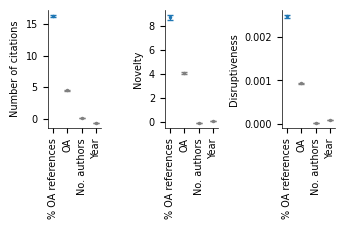

In [52]:
ax = plt.subplot(1, 3, 1)
drawCoefficientPlot(m_impact, ax)
ax.set_ylabel('Number of citations')

ax = plt.subplot(1, 3, 2)
drawCoefficientPlot(m_novelty, ax)
ax.set_ylabel('Novelty')

ax = plt.subplot(1, 3, 3)
drawCoefficientPlot(m_disruption, ax)
ax.set_ylabel('Disruptiveness')
ax.set_yticks([0, 0.001, 0.002])

set_size(7*CM, 4.5*CM)

plt.tight_layout()

plt.savefig('../figures/Impact_novelty_disruptiveness_regression.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Regress on residuals

In [96]:
%%time
m = ols('CitationCount_within ~ Year + is_oa + AuthorCount', data=toRegFiltered).fit()

CPU times: user 16.1 s, sys: 2.1 s, total: 18.2 s
Wall time: 18.3 s


In [97]:
%%time
toRegFiltered = (
    toRegFiltered.assign(Residuals= m.resid)

    .assign(Percent_within2=lambda df: df.Percent_within.apply(lambda x: x**2))
    .assign(Percent_within3=lambda df: df.Percent_within.apply(lambda x: x**3))
)

CPU times: user 42.6 s, sys: 5.24 s, total: 47.8 s
Wall time: 48.2 s


In [98]:
assert(toRegFiltered.isna().any().any() == False)

In [100]:
%%time
m1 = ols('Residuals ~ Percent_within', data=toRegFiltered).fit()
m2 = ols('Residuals ~ Percent_within + Percent_within2', data=toRegFiltered).fit()
m3 = ols('Residuals ~ Percent_within + Percent_within2 + Percent_within3', data=toRegFiltered).fit()

CPU times: user 40.2 s, sys: 4.81 s, total: 45 s
Wall time: 45.4 s


In [101]:
summary_col([m1, m2, m3])

,Residuals I,Residuals II,Residuals III
Intercept,0.1444,0.3498,0.6372
,(0.0205),(0.0246),(0.0251)
Percent_within,15.0724,14.4812,22.3855
,(0.1174),(0.1238),(0.1792)
Percent_within2,,-6.9449,-22.5153
,,(0.4625),(0.5283)
Percent_within3,,,-91.1447
,,,(1.4942)
R-squared,0.0003,0.0003,0.0004
R-squared Adj.,0.0003,0.0003,0.0004


In [109]:
%%time
regionalMean = (
    toRegFiltered.pipe(printShape)
    .merge(paperSubRegion, on='PaperID')
    .pipe(printShape)
    
    .groupby('ProcessedSubRegion').Percent_within.mean().reset_index()
    .pipe(printShape)
)

(53378532, 14)  
(40223563, 15)  
(14, 2)  
CPU times: user 37.8 s, sys: 4.45 s, total: 42.3 s
Wall time: 42.7 s


In [110]:
regionsToPlot = (
    regionalMean.sort_values(by=['Percent_within']).head(13)
    .query('ProcessedSubRegion != "Western Asia"')
    .query('ProcessedSubRegion != "Southern Asia"')
    .query('ProcessedSubRegion != "Northern Europe"')
    .query('ProcessedSubRegion != "Eastern Europe"')
    .query('ProcessedSubRegion != "Southern Europe"')
    

    .reset_index(drop=True)
    .pipe(printShape)
)

(8, 2)  


In [111]:
regionsToPlot

,ProcessedSubRegion,Percent_within
0,Central Asia,-0.044891
1,South-eastern Asia,-0.037492
2,Sub-Saharan Africa,-0.032737
3,Latin America and the Caribbean,-0.032180
4,Eastern Asia,-0.017945
5,Western Europe,-0.016735
6,Northern America,-0.011075
7,Oceania,-0.006771


In [112]:
from matplotlib.pyplot import cm

colors = cm.RdYlBu([0, 0.05, 0.1, 0.15, 0.2, 0.75, 0.8, 0.85, 0.9, 0.95, 1])

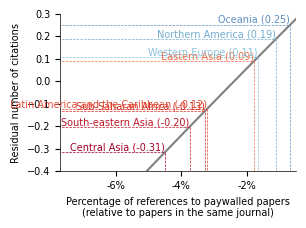

In [113]:
fig = plt.figure(figsize=(8.2*CM, 5*CM))
ax = plt.gca()

x = np.linspace(-1, 1, 1000)
ax.plot(x, getCurve(x, m2), label='Quadratic', color='grey')

ax.set_xlabel('Percentage of references to paywalled papers\n(relative to papers in the same journal)')
ax.set_ylabel('Residual number of citations')

for ind, row in regionsToPlot.iterrows():

    percent = row['Percent_within']
    color = colors[ind]
    ax.plot([percent, percent], [-25, getCurve(percent, m2)], ls='--', color=color, lw=.5)
    ax.plot([-1, percent], [getCurve(percent, m2), getCurve(percent, m2)], ls='--', color=color, lw=.5)
    ax.annotate(
        f'{row["ProcessedSubRegion"]} ({getCurve(percent, m2):.2f})', (percent, getCurve(percent, m2)),
        color=color, horizontalalignment='right', verticalalignment='bottom'
    )

ax.set_xlim(-0.077, -0.005)
ax.set_ylim(-0.4, 0.3)

ax.set_xticks([-0.06, -0.04, -0.02])
ax.set_xticklabels(['-6%', '-4%', '-2%'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

set_size(6*CM, 4*CM, ax)

plt.savefig('../figures/Impact_paywalled_subregional_estimation.pdf', bbox_inches = 'tight', pad_inches = 0)